In [13]:

import numpy as np
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)


In [14]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from collections import Counter

DATASET_PATH = "/kaggle/input/animal-datasets/animal_dataset" 

IMG_SIZE = 32
K_VALUES = [1, 3, 5, 7, 9, 11]
N_FOLDS = 5

print("Configuration Set.")
print(f"Dataset Path: {DATASET_PATH}")

Configuration Set.
Dataset Path: /kaggle/input/animal-datasets/animal_dataset


In [15]:
def load_data(path, img_size):
    X_list = []
    y_list = []
    
    if not os.path.exists(path):
        print(f"Error: Path '{path}' not found.")
        return np.array([]), np.array([]), []

    classes = sorted([d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))])
    print(f"Classes Found: {classes}")

    for label_idx, cls in enumerate(classes):
        cls_dir = os.path.join(path, cls)
        for fname in os.listdir(cls_dir):
            fpath = os.path.join(cls_dir, fname)
            img = cv2.imread(fpath)
            if img is None: continue
            
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            gray = cv2.resize(gray, (img_size, img_size))
            
            flat = gray.flatten().astype(np.float32)
            
            X_list.append(flat)
            y_list.append(label_idx)
            
    return np.array(X_list), np.array(y_list), classes

In [16]:
X, y, classes = load_data(DATASET_PATH, IMG_SIZE)

if len(X) > 0:
    print(f"Successfully loaded {X.shape[0]} images.")
    print(f"Feature vector shape: {X.shape[1]}")
else:
    print("WARNING: No images loaded. Please check your DATASET_PATH in Cell 1.")

Classes Found: ['cat', 'dog', 'panda']
Successfully loaded 300 images.
Feature vector shape: 1024


In [17]:
def knn_predict(X_train, y_train, X_test, K=3, metric='L2'):
    preds = []
    for test_row in X_test:
        if metric == 'L1':
            dists = np.sum(np.abs(X_train - test_row), axis=1)
        else:
            dists = np.sqrt(np.sum((X_train - test_row)**2, axis=1))

        nearest_idxs = np.argsort(dists)[:K]
        nearest_labels = y_train[nearest_idxs]
        vote = Counter(nearest_labels).most_common(1)[0][0]
        preds.append(vote)
    return np.array(preds)

In [18]:
if len(X) > 0:
    kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
    
    avg_l1 = []
    avg_l2 = []

    print(f"Running {N_FOLDS}-Fold Cross-Validation...")
    
    for k in K_VALUES:
        fold_accs_l1 = []
        fold_accs_l2 = []
        
        for train_ix, val_ix in kf.split(X):
            X_tr, X_val = X[train_ix], X[val_ix]
            y_tr, y_val = y[train_ix], y[val_ix]
            
            p_l1 = knn_predict(X_tr, y_tr, X_val, K=k, metric='L1')
            fold_accs_l1.append(np.mean(p_l1 == y_val))
        
            p_l2 = knn_predict(X_tr, y_tr, X_val, K=k, metric='L2')
            fold_accs_l2.append(np.mean(p_l2 == y_val))
            
        mean_l1 = np.mean(fold_accs_l1)
        mean_l2 = np.mean(fold_accs_l2)
        
        avg_l1.append(mean_l1)
        avg_l2.append(mean_l2)
        
        print(f"K={k} | L1 Acc: {mean_l1:.3f} | L2 Acc: {mean_l2:.3f}")

Running 5-Fold Cross-Validation...
K=1 | L1 Acc: 0.373 | L2 Acc: 0.357
K=3 | L1 Acc: 0.407 | L2 Acc: 0.367
K=5 | L1 Acc: 0.393 | L2 Acc: 0.370
K=7 | L1 Acc: 0.403 | L2 Acc: 0.367
K=9 | L1 Acc: 0.397 | L2 Acc: 0.400
K=11 | L1 Acc: 0.413 | L2 Acc: 0.410


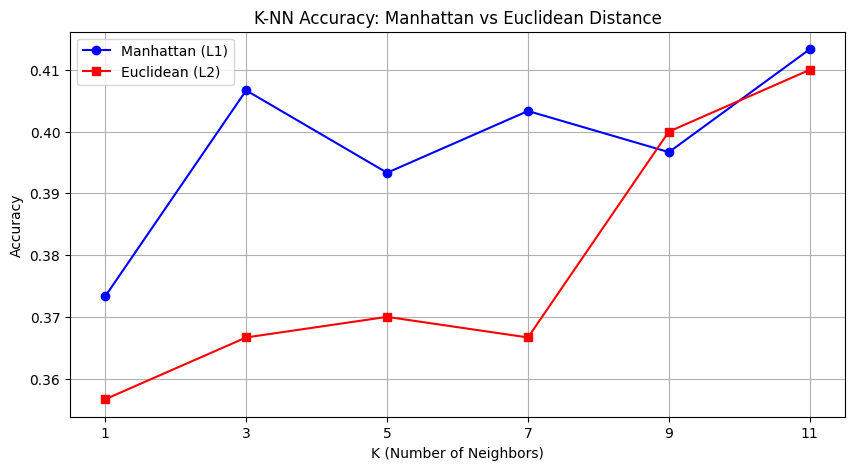

In [19]:
if len(X) > 0:
    plt.figure(figsize=(10, 5))
    plt.plot(K_VALUES, avg_l1, marker='o', label='Manhattan (L1)', color='blue')
    plt.plot(K_VALUES, avg_l2, marker='s', label='Euclidean (L2)', color='red')
    plt.title('K-NN Accuracy: Manhattan vs Euclidean Distance')
    plt.xlabel('K (Number of Neighbors)')
    plt.ylabel('Accuracy')
    plt.xticks(K_VALUES)
    plt.legend()
    plt.grid(True)
    plt.show()

In [20]:
if len(X) > 0:
    best_l1_idx = np.argmax(avg_l1)
    best_l2_idx = np.argmax(avg_l2)
    max_l1 = avg_l1[best_l1_idx]
    max_l2 = avg_l2[best_l2_idx]

    print("="*30)
    print("DISCUSSION & ANALYSIS")
    print("="*30)
    print(f"Best L1 Accuracy: {max_l1:.2%} at K={K_VALUES[best_l1_idx]}")
    print(f"Best L2 Accuracy: {max_l2:.2%} at K={K_VALUES[best_l2_idx]}")
    
    if max_l1 > max_l2:
        winner = 'L1'
        best_k = K_VALUES[best_l1_idx]
        print("\nConclusion: Manhattan (L1) distance performed better.")
        print("Reasoning: L1 distance is often preferred for high-dimensional data (like image pixels)")
        print("because it sums absolute differences, making it less sensitive to outliers than L2.")
    else:
        winner = 'L2'
        best_k = K_VALUES[best_l2_idx]
        print("\nConclusion: Euclidean (L2) distance performed better (or equal).")
        print("Reasoning: Euclidean distance represents the shortest straight-line path,")
        print("which can be effective when pixel variations are smooth across classes.")

DISCUSSION & ANALYSIS
Best L1 Accuracy: 41.33% at K=11
Best L2 Accuracy: 41.00% at K=11

Conclusion: Manhattan (L1) distance performed better.
Reasoning: L1 distance is often preferred for high-dimensional data (like image pixels)
because it sums absolute differences, making it less sensitive to outliers than L2.



TOP 5 PREDICTIONS (Using Best Model: L1, K=11)


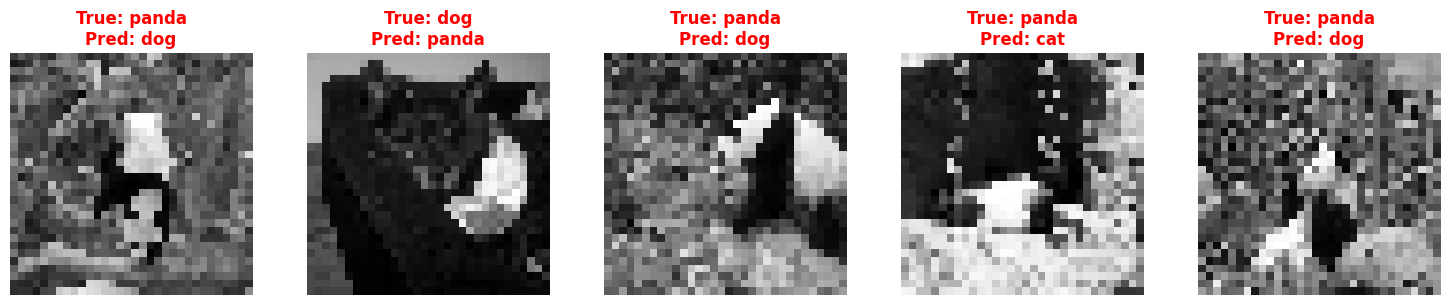

In [21]:
if len(X) > 0:
    print("\n" + "="*30)
    print(f"TOP 5 PREDICTIONS (Using Best Model: {winner}, K={best_k})")
    print("="*30)

    np.random.seed(100) 
    test_indices = np.random.choice(len(X), 5, replace=False)
    
    plt.figure(figsize=(15, 3))
    
    for i, idx in enumerate(test_indices):
        img_flat = X[idx]
        true_label = classes[y[idx]]
       
        X_train_temp = np.delete(X, idx, axis=0)
        y_train_temp = np.delete(y, idx, axis=0)
        
        pred_idx = knn_predict(X_train_temp, y_train_temp, img_flat.reshape(1, -1), K=best_k, metric=winner)[0]
        pred_label = classes[pred_idx]

        ax = plt.subplot(1, 5, i+1)
        ax.imshow(img_flat.reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
        
        color = 'green' if true_label == pred_label else 'red'
        ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=color, fontweight='bold')
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()